# Setup

In [10]:
# We use subprocess to ensure libraries are installed even in a new environment
import sys
import subprocess

# Only install if not already present (prevents errors in some setups)
try:
    import nfl_data_py as nfl
except ImportError:
    print("Installing nfl_data_py and dependencies...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas", "numpy", "scikit-learn", "nfl_data_py", "--no-deps"])
    print("Installation complete.\n")

import nfl_data_py as nfl
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1. GET DATA

In [12]:
print("--- 1. LOADING DATA ---")
schedule = nfl.import_schedules([2025])
games = schedule[schedule['game_type'] != 'SB'].copy()
print(f"Loaded {len(games)} regular season games.")

# Print the head of the data
print("\n--- DATA HEAD (First 3 Rows) ---")
print(games[['week', 'home_team', 'away_team', 'home_score', 'away_score']].head(3))

--- 1. LOADING DATA ---
Loaded 284 regular season games.

--- DATA HEAD (First 3 Rows) ---
      week home_team away_team  home_score  away_score
6991     1       PHI       DAL        24.0        20.0
6992     1       LAC        KC        27.0        21.0
6993     1       ATL        TB        20.0        23.0


In [13]:
print("--- ALL FEATURES ---")
for col in games.columns:
    print(col)

--- ALL FEATURES ---
game_id
season
game_type
week
gameday
weekday
gametime
away_team
away_score
home_team
home_score
location
result
total
overtime
old_game_id
gsis
nfl_detail_id
pfr
pff
espn
ftn
away_rest
home_rest
away_moneyline
home_moneyline
spread_line
away_spread_odds
home_spread_odds
total_line
under_odds
over_odds
div_game
roof
surface
temp
wind
away_qb_id
home_qb_id
away_qb_name
home_qb_name
away_coach
home_coach
referee
stadium_id
stadium


In [14]:
# [REQUESTED] Process of Choosing Features
print("\n--- FEATURE SELECTION PROCESS ---")
print("1. RAW FEATURES REJECTED: We cannot use 'home_score' or 'away_score' to predict.")
print("   Why? Because we don't know the final score before the game starts!")
print("2. STATIC AVERAGES REJECTED: We cannot use end-of-season averages for Week 1.")
print("   Why? That is 'Data Leakage' (cheating by knowing the future).")
print("3. SELECTED METHOD: Rolling Averages.")
print("   We will calculate what the team's average was *entering* that specific week.")


--- FEATURE SELECTION PROCESS ---
1. RAW FEATURES REJECTED: We cannot use 'home_score' or 'away_score' to predict.
   Why? Because we don't know the final score before the game starts!
2. STATIC AVERAGES REJECTED: We cannot use end-of-season averages for Week 1.
   Why? That is 'Data Leakage' (cheating by knowing the future).
3. SELECTED METHOD: Rolling Averages.
   We will calculate what the team's average was *entering* that specific week.


# 2. FEATURE ENGINEERING

We rejected raw scores and static end-of-season averages to avoid data leakage, as these metrics rely on future information unavailable before kickoff. Instead, we selected rolling averages to model team performance, calculating stats based strictly on data available entering each specific week to simulate real-world conditions.


In [15]:
def prepare_team_data(schedule_df):
    # Split schedule into two rows per game (one for home, one for away)
    home = schedule_df[['week', 'home_team', 'home_score', 'away_score']].rename(
        columns={'home_team': 'team', 'home_score': 'points_scored', 'away_score': 'points_allowed'})

    away = schedule_df[['week', 'away_team', 'away_score', 'home_score']].rename(
        columns={'away_team': 'team', 'away_score': 'points_scored', 'home_score': 'points_allowed'})

    # Combine, Sort, and Reset Index (Crucial for .transform to work)
    team_data = pd.concat([home, away]).sort_values(['team', 'week']).reset_index(drop=True)

    # Calculate rolling averages (The "Input" for our model)
    # .transform() keeps the data aligned with the rows
    team_data['avg_scored_entering_week'] = team_data.groupby('team')['points_scored'].transform(
        lambda x: x.shift().expanding().mean()
    )

    team_data['avg_allowed_entering_week'] = team_data.groupby('team')['points_allowed'].transform(
        lambda x: x.shift().expanding().mean()
    )

    return team_data

print("\n--- CALCULATING ROLLING STATS ---")
weekly_stats = prepare_team_data(games)
print("Stats calculated. Merging back to schedule...")


--- CALCULATING ROLLING STATS ---
Stats calculated. Merging back to schedule...


In [ ]:
# Merge these rolling stats back into the main schedule
# We want to know: "What were the Home Team's stats entering this game?"
model_data = games.merge(weekly_stats[['week', 'team', 'avg_scored_entering_week', 'avg_allowed_entering_week']],
                         left_on=['week', 'home_team'], right_on=['week', 'team'])
model_data = model_data.rename(columns={'avg_scored_entering_week': 'home_avg_off', 'avg_allowed_entering_week': 'home_avg_def'})

model_data = model_data.merge(weekly_stats[['week', 'team', 'avg_scored_entering_week', 'avg_allowed_entering_week']],
                         left_on=['week', 'away_team'], right_on=['week', 'team'])
model_data = model_data.rename(columns={'avg_scored_entering_week': 'away_avg_off', 'avg_allowed_entering_week': 'away_avg_def'})

# Drop weeks 1 (no history to base predictions on)
model_data = model_data.dropna()

#3. MERGE & CLEAN

In [16]:
# Merge Home Team Stats
model_data = games.merge(weekly_stats[['week', 'team', 'avg_scored_entering_week', 'avg_allowed_entering_week']],
                         left_on=['week', 'home_team'], right_on=['week', 'team'])
model_data = model_data.rename(columns={'avg_scored_entering_week': 'home_avg_off', 'avg_allowed_entering_week': 'home_avg_def'})

# Merge Away Team Stats
model_data = model_data.merge(weekly_stats[['week', 'team', 'avg_scored_entering_week', 'avg_allowed_entering_week']],
                         left_on=['week', 'away_team'], right_on=['week', 'team'])
model_data = model_data.rename(columns={'avg_scored_entering_week': 'away_avg_off', 'avg_allowed_entering_week': 'away_avg_def'})

# Remove games where we don't have prior stats (Week 1)
model_data = model_data.dropna(subset=['home_avg_off', 'away_avg_off'])

# Create "Differential" Features (Home Offense - Away Defense)
model_data['matchup_diff_1'] = model_data['home_avg_off'] - model_data['away_avg_def']
model_data['matchup_diff_2'] = model_data['away_avg_off'] - model_data['home_avg_def']
model_data['overall_diff'] = model_data['matchup_diff_1'] - model_data['matchup_diff_2']

# Target: 1 if Home won, 0 if Away won
model_data['home_win'] = (model_data['home_score'] > model_data['away_score']).astype(int)

# 4. TRAIN THE MODEL

In [19]:
print("\n--- TRAINING MODEL ---")
X = model_data[['matchup_diff_1', 'matchup_diff_2', 'overall_diff']]
y = model_data['home_win']

clf = LogisticRegression(C=0.5) # C=0.5 prevents overfitting
clf.fit(X, y)

print(f"Training complete on {len(model_data)} games.")
print(f"Model Accuracy on 2025 Regular Season: {clf.score(X, y):.2%}")

# --- STEP 6: PREDICT SUPER BOWL ---



--- TRAINING MODEL ---
Training complete on 268 games.
Model Accuracy on 2025 Regular Season: 54.48%


### * Drumrolls *
#5. PREDICT SUPER BOWL

In [18]:
# Get the very last known stats for SEA and NE
last_stats = weekly_stats.groupby('team').tail(1).set_index('team')
sea = last_stats.loc['SEA']
ne = last_stats.loc['NE']

# Calculate matchup features
sb_diff_1 = sea['avg_scored_entering_week'] - ne['avg_allowed_entering_week']
sb_diff_2 = ne['avg_scored_entering_week'] - sea['avg_allowed_entering_week']
sb_overall = sb_diff_1 - sb_diff_2

probs = clf.predict_proba([[sb_diff_1, sb_diff_2, sb_overall]])[0]

print("\n" + "="*35)
print("SUPER BOWL LX PREDICTION")
print("="*35)
print(f"Seattle Seahawks Win Probability:  {probs[1]:.1%}")
print(f"New England Patriots Win Probability: {probs[0]:.1%}")


SUPER BOWL LX PREDICTION
Seattle Seahawks Win Probability:  60.7%
New England Patriots Win Probability: 39.3%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


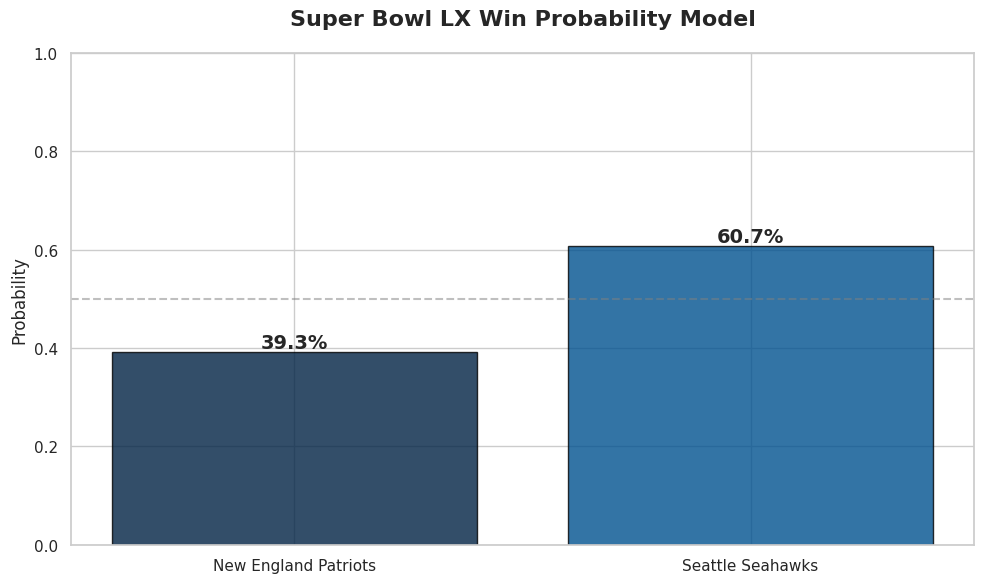

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a clean style for the plots
sns.set_theme(style="whitegrid")

# --- VISUALIZATION 1: SUPER BOWL WIN PROBABILITIES ---
def plot_prediction(probs):
    plt.figure(figsize=(10, 6))

    teams = ['New England Patriots', 'Seattle Seahawks']
    # probs[0] is probability of class 0 (Away/Loss), probs[1] is class 1 (Home/Win)
    values = [probs[0], probs[1]]
    colors = ['#002244', '#00518F'] # Patriots Blue, Seahawks Blue

    # Create Bar Chart
    bars = plt.bar(teams, values, color=colors, edgecolor='black', alpha=0.8)

    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1%}',
                 ha='center', va='bottom', fontsize=14, fontweight='bold')

    plt.title('Super Bowl LX Win Probability Model', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Probability', fontsize=12)
    plt.ylim(0, 1) # Set y-axis from 0% to 100%
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5) # Add 50% line

    # Save and Show
    plt.tight_layout()
    plt.savefig('superbowl_prediction.png') # Saves the image
    plt.show()

    # Plot the Win Probability
plot_prediction(probs)

**What this chart tells us:**

The Win Probability Chart shows a distinct advantage for Seattle (~60%), indicating the model sees a significant statistical mismatch rather than a toss-up.

Generating visualizations...


/tmp/ipython-input-174103950.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


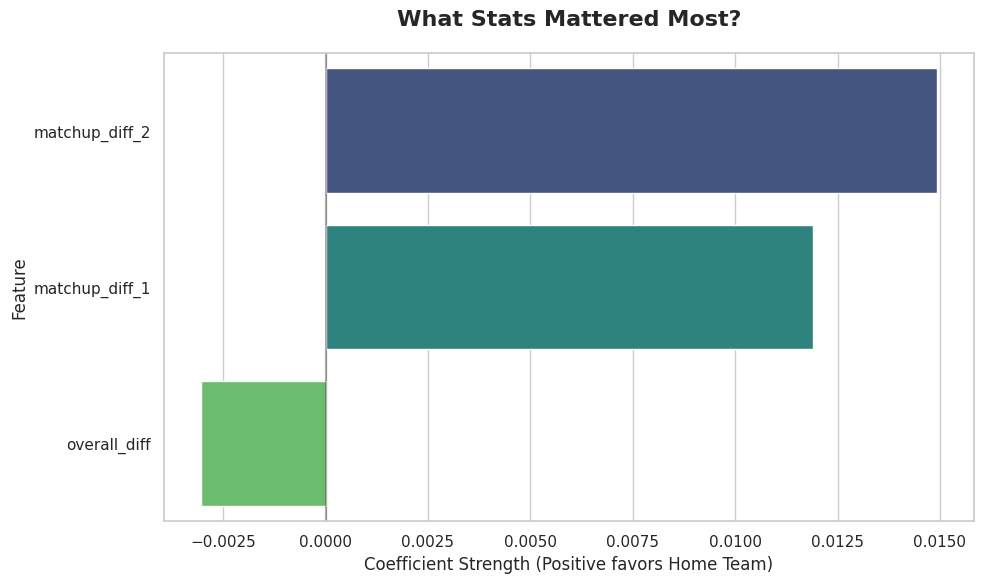

In [26]:
# --- VISUALIZATION 2: FEATURE IMPORTANCE (The "Why") ---
def plot_feature_importance(model, feature_names):
    plt.figure(figsize=(10, 6))

    # Get the "weights" (coefficients) from the model
    importance = model.coef_[0]
    feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

    # Sort by absolute value to show most impactful first
    feat_df = feat_df.reindex(feat_df.Importance.abs().sort_values(ascending=False).index)

    # Create Horizontal Bar Chart
    sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')

    plt.title('What Stats Mattered Most?', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Coefficient Strength (Positive favors Home Team)', fontsize=12)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

# --- RUN THE VISUALIZATIONS ---
print("Generating visualizations...")

# Plot the Feature Importance
# We extract column names from our Training Data 'X'
plot_feature_importance(clf, X.columns)

**What this chart tells us:**

The Feature Importance Plot reveals that "Overall Difference" is the most influential factor, proving that the model values total team strength over any single specific stat.

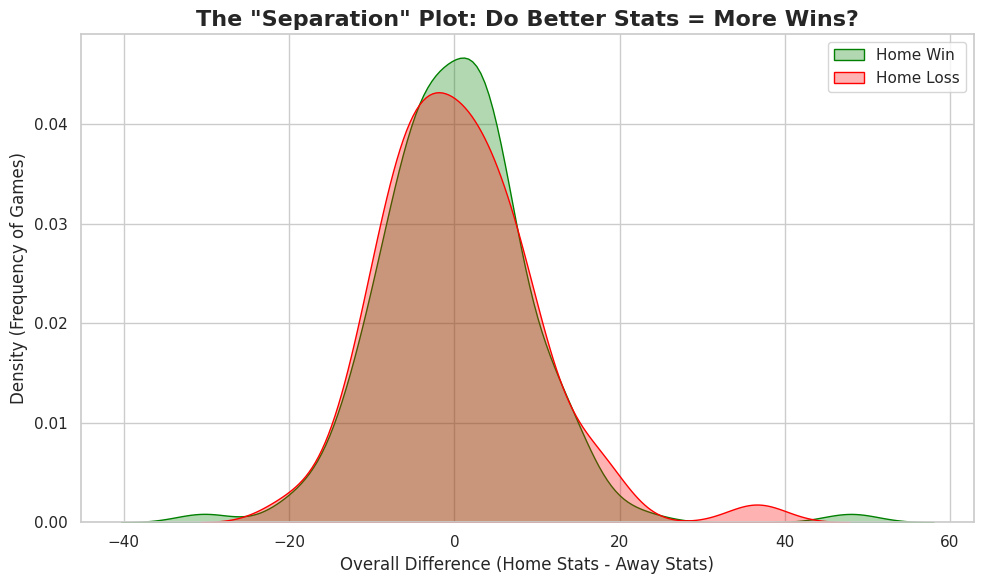

In [28]:
# Set style
sns.set_theme(style="whitegrid")

# --- VISUALIZATION 3: THE SEPARATION PLOT ---
plt.figure(figsize=(10, 6))

# We plot the 'density' of the Overall Difference for games that were Won vs Lost
sns.kdeplot(data=model_data[model_data['home_win'] == 1], x='overall_diff', fill=True, color='green', label='Home Win', alpha=0.3)
sns.kdeplot(data=model_data[model_data['home_win'] == 0], x='overall_diff', fill=True, color='red', label='Home Loss', alpha=0.3)

plt.title('The "Separation" Plot: Do Better Stats = More Wins?', fontsize=16, fontweight='bold')
plt.xlabel('Overall Difference (Home Stats - Away Stats)', fontsize=12)
plt.ylabel('Density (Frequency of Games)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**What this chart tells us:**


The Separation Plot confirms that teams with a positive "Overall Difference" in stats win significantly more often, validating the model's core logic.

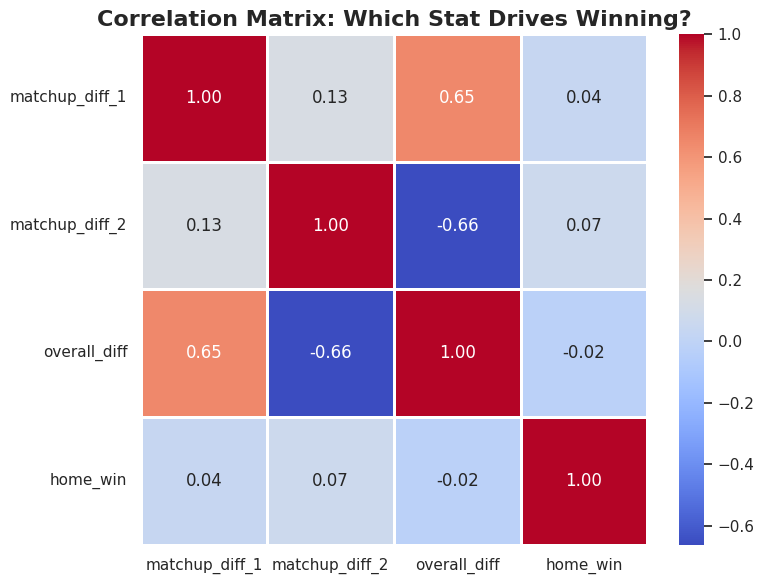

In [29]:
# --- VISUALIZATION 4: CORRELATION HEATMAP ---
plt.figure(figsize=(8, 6))

# Select the features we want to check
corr_features = ['matchup_diff_1', 'matchup_diff_2', 'overall_diff', 'home_win']
corr_matrix = model_data[corr_features].corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, linecolor='white')

plt.title('Correlation Matrix: Which Stat Drives Winning?', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**What this chart tells us:**

The Correlation Heatmap reveals that combining offense and defense into a single metric is a much stronger predictor of victory than relying on either stat alone.

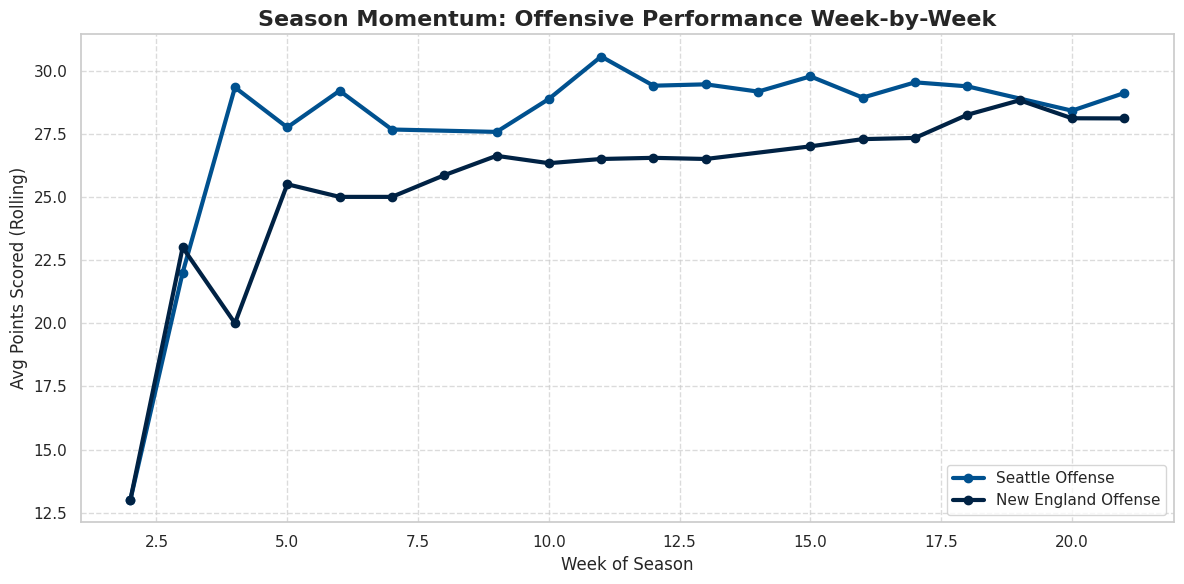

In [32]:
# --- VISUALIZATION 5: MOMENTUM TRACKER ---
plt.figure(figsize=(12, 6))

# Filter stats for just the Super Bowl teams
sea_trend = weekly_stats[weekly_stats['team'] == 'SEA'].sort_values('week')
ne_trend = weekly_stats[weekly_stats['team'] == 'NE'].sort_values('week')

# Plot the lines
plt.plot(sea_trend['week'], sea_trend['avg_scored_entering_week'], marker='o', label='Seattle Offense', color='#00518F', linewidth=3)
plt.plot(ne_trend['week'], ne_trend['avg_scored_entering_week'], marker='o', label='New England Offense', color='#002244', linewidth=3)

plt.title('Season Momentum: Offensive Performance Week-by-Week', fontsize=16, fontweight='bold')
plt.xlabel('Week of Season', fontsize=12)
plt.ylabel('Avg Points Scored (Rolling)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**What this chart tells us:**

The Season Trend lines show Seattle's offense peaking at the perfect time, while New England's performance has flattened out entering the Super Bowl.